<a href="https://colab.research.google.com/github/colaresm/Prevendo-a-mobilidade-em-esta-es-de-transporte-com-modelo-ARIMAb/blob/main/Prevendo_a_mobilidade_em_esta%C3%A7%C3%B5es_de_transporte_com_modelo_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
from google.colab import drive 
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose 
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Prevendo a mobilidade em estações de transporte público
***Sobre os dados:***</br>
Mobilidade: Os dados de mobilidade foram obtidos em Community Mobility Reports, o qual fornece gráficos com tendências de deslocamento ao longo do tempo por região e em diferentes categorias de locais, como varejo e lazer, mercados e farmácias, parques, estações de transporte público, locais de trabalho e áreas residenciais.

Utilizaremos apenas os dados relacionados as estações de transporte para a geração do modelo ARIMA.


In [116]:
path ='/content/drive/MyDrive/datasets_ml/mobility_report_brazil.csv'
df = pd.read_csv(path)
df = df.loc[df['sub region 2'] == 'Fortaleza']
df.describe()

,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,-37.501217,-0.615572,-54.051095,-26.618005,-21.715328,11.992701
std,24.392959,17.193253,20.463646,24.015799,20.511965,6.385383
min,-86.000000,-77.000000,-96.000000,-76.000000,-76.000000,-1.000000
25%,-58.000000,-10.000000,-69.000000,-46.000000,-34.000000,8.000000
50%,-30.000000,3.000000,-52.000000,-22.000000,-17.000000,10.000000
75%,-19.000000,11.000000,-40.000000,-5.000000,-7.000000,17.000000
max,11.000000,49.000000,5.000000,40.000000,15.000000,28.000000


In [117]:
def mediamovel2(dados,janela):
  numbers = dados
  window_size = janela
  numbers_series = pd.Series(numbers)
  windows = numbers_series.rolling(window_size)
  moving_averages = windows.mean()
  moving_averages_list = moving_averages.tolist()
  without_nans = moving_averages_list[window_size - 1:]
  return np.round(without_nans,4)
def yeo(dados):
  y_yeo, lmbda = stats.yeojohnson(dados)
  return y_yeo

# Análise dos dados

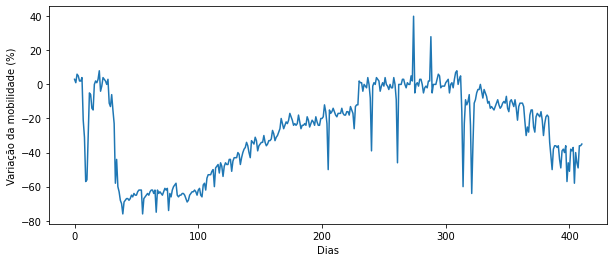

In [118]:
plt.figure(figsize=(10,4))
plt.xlabel('Dias')
plt.ylabel('Variação da mobilidade (%)')
plt.plot(np.array(df['transit stations']))


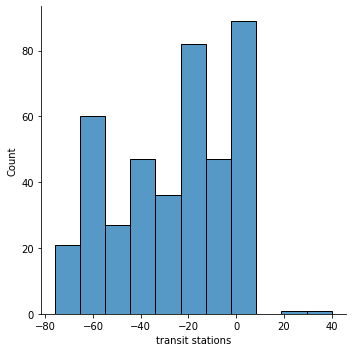

In [119]:
sns.displot(df['transit stations'])

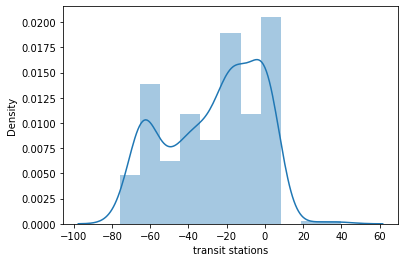

In [120]:
sns.distplot(df['transit stations'])

In [121]:
df['transit stations'].skew()

-0.3366182594087948

{'boxes': [<matplotlib.lines.Line2D at 0x7f5b3005a750>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5b3005f790>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5b300667d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5b30066290>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5b3005acd0>,
  <matplotlib.lines.Line2D at 0x7f5b3005f250>]}

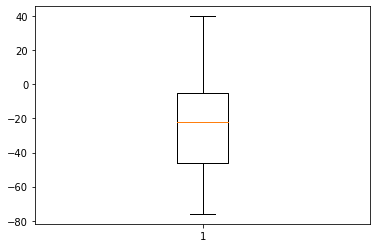

In [122]:
plt.boxplot(df['transit stations'])

Podemos observar que os dados apresentam uma distribuição não simétrica de acordo com o que de foi observado no valor da skews de -0.336, esse valor indica que o quanto uma distribuição "pesa" mais para a esquerda ou direita.

Observando o bloxplot verifica-se não haver a presença de outliers(pontos fora da curva)

# Componentes da série

Uma série temporal pode ser decomposta em três componentes:

*   X(t)- O valor médio da série.
*   T(t)- Tendência
*   S(t)- Sazonal(periódica)
*   N(t)- Ruído(parte aleatória)
<br>
Assim uma série temporal $X(t)$ pode ser decomposta de da seguinte forma aditiva:
$$ Y(t)= X(t)+T(t)+S(t)+N(t)$$
Um modelo aditivo é linear onde as mudanças ao longo do tempo são feitas de forma consistente pela mesma quantidade.Uma tendência linear é uma linha reta.
Uma sazonalidade linear tem a mesma frequência (largura dos ciclos) e amplitude (altura dos ciclos).
<br>

Ou da seguinte forma multiplicativa:

$$ Y(t)= X(t)T(t)S(t)N(t)$$

Um modelo multiplicativo é não linear, como quadrático ou exponencial. As alterações aumentam ou diminuem com o tempo.Uma tendência não linear é uma linha curva.Uma sazonalidade não linear tem uma frequência e / ou amplitude crescente ou decrescente ao longo do tempo.

## Extraindo uma tendência de um série
Uma forma de extrair uma tendência de um série é pelo uso de médias móveis, que é um estimador calculado a partir de amostras sequenciais de uma série temporal.

$$  Y_{AM} = \frac{1}{N}\sum_{i=0}^{N}Y(t-i)$$
A expressão anterior calcula a média dos $N$ pontos anteriores.

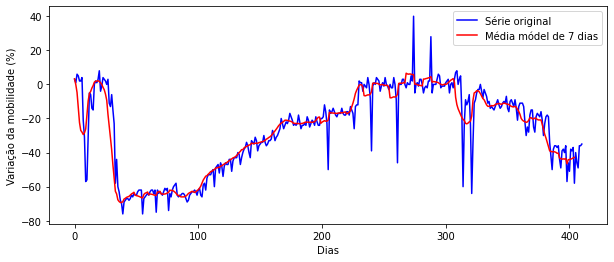

In [123]:
y_7 = mediamovel2(df['transit stations'],7)
plt.figure(figsize=(10,4))
plt.xlabel('Dias')
plt.ylabel('Variação da mobilidade (%)')
plt.plot(np.array(df['transit stations']),label="Série original",color='b')
plt.plot(y_7,label="Média módel de 7 dias",color='r')
plt.legend()

In [124]:
df.reset_index(inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
series = df['transit stations']
result = seasonal_decompose(series, model='additive')

Text(0.5, 1.0, 'Resíduo')

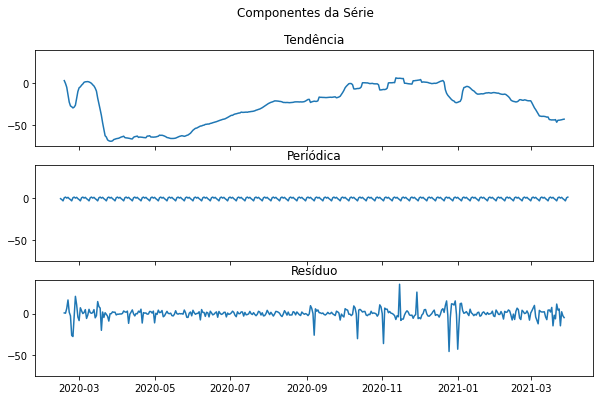

In [125]:
fig, axs = plt.subplots(3, sharex=True, sharey=True,figsize=(10,6))
fig.suptitle('Componentes da Série')
axs[0].plot(result.trend)
axs[0].set_title("Tendência")
axs[1].plot(result.seasonal)
axs[1].set_title("Periódica")
axs[2].plot(result.resid)
axs[2].set_title("Resíduo")

Vericamos que componente periódica está bem definida, o correspondendo a um cillo de aproximadamente sete dias. Em termos da componente de resíduo obserrva-se que não nenhum compontamento sazonal o que indica que a seperação foi bem sucedida.

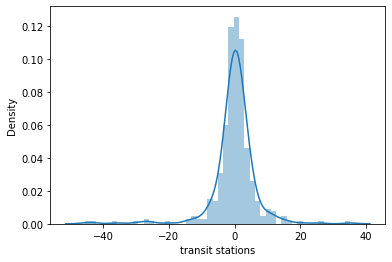

In [126]:
sns.distplot(result.resid)

In [127]:
print("Média:",np.mean(result.resid))
print("Desvio padrão:",np.std(result.resid))
print("Skew:",skew(result.resid[~np.isnan(result.resid)]))

Média: -0.03030976455918341
Desvio padrão: 6.655284865192524
Skew: -1.8715468244766604


In [128]:
y_train = series[0: int(0.8*len(series))  ]
y_test = series[int(0.8*len(series)) :int(len(series))   ]

# Modelo ARIMA <br>

É utilizado para modelar séries temporais, processos,  não estacionários, que consiste em apliocar a d-ésima diferença em um modelo ARMA(p,q). Então um modelo ARIMA(p,d,q) tem as seguintes componentes:


*   p: Quantidade de lags que foram devem ser incluídos no modelo.
*    d: Número de vezes que as observações serão diferenciadas.
*  q: O tamanho de uma janela de média móvel. Também chamada de ordem de média móvel.





In [129]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


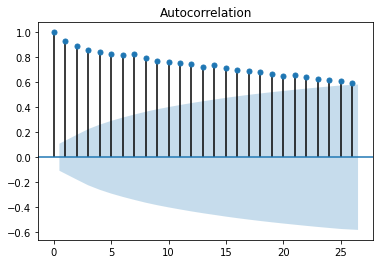

In [130]:
plot_acf(y_train, lags=26)
pyplot.show()

In [131]:
from statsmodels.tsa.arima_model import ARIMA
model =ARIMA(y_train, order=(7,1,1)).fit()


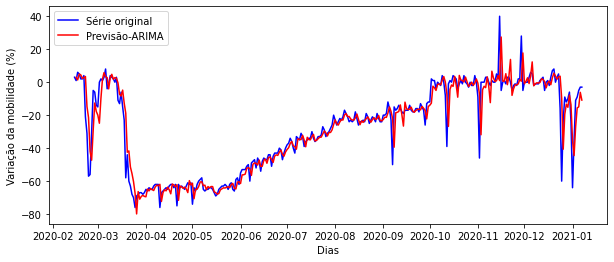

In [132]:
plt.figure(figsize=(10,4))
plt.plot(y_train,label="Série original",color='b')
plt.plot(model.predict(typ='levels'),label="Previsão-ARIMA",color='r')
plt.xlabel('Dias')
plt.ylabel('Variação da mobilidade (%)')
plt.legend()

In [133]:
print("MSE:",(model.resid**2).mean())

MSE: 75.44346215595012


A transformação de Yeo-Johnson permite estabilizar a variância   e aproximar os dados  à distribuição normal, além de  melhorar a  correlação  entre variáveis. Onde $y_i$ corresponde ao vetor de dados que será transformado e $\lambda$ pode ser qualquer número real,. 

$$
y_i^{\lambda }=\left\{\begin{matrix}
 \left (\left ( y_i+1 \right )^{\lambda } -1 \right )/\lambda  & se \ \lambda  \neq 0,y\geq 0 \\ 
  log\left ( y_i +1 \right ) &se \ \lambda = 0,y \geq  0 \\ 
-\left [\left ( -yi+1 \right )  ^{\left ( 2-\lambda \right )}-1\right ]/\left ( 2-\lambda \right ) &  se \ \lambda  \neq 2,y < 0       \\ 
 - log\left ( -y_i +1 \right ) & se \ \lambda  = 2,y < 0 
\end{matrix}\right.
$$

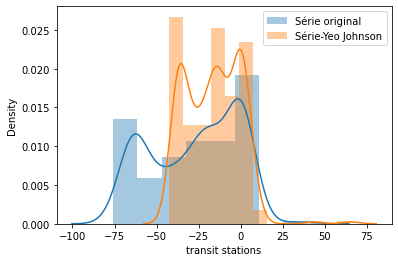

In [134]:
sns.distplot(y_train,label="Série original")
sns.distplot(yeo(y_train),label="Série-Yeo Johnson")
plt.legend()

In [135]:
from statsmodels.tsa.arima_model import ARIMA
model =ARIMA(yeo(y_train), order=(7,1,1)).fit()


In [136]:
print("MSE:",(model.resid**2).mean())

MSE: 51.1916163897446


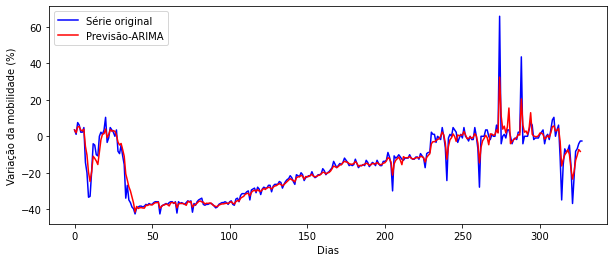

In [137]:
plt.figure(figsize=(10,4))
plt.plot(yeo(y_train),label="Série original",color='b')
plt.plot(model.predict(typ='levels'),label="Previsão-ARIMA",color='r')
plt.xlabel('Dias')
plt.ylabel('Variação da mobilidade (%)')
plt.legend()

# Resultados

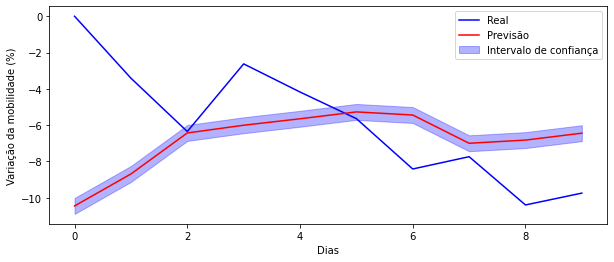

In [151]:
plt.figure(figsize=(10,4))
y=model.forecast(steps=10)[0]
x=np.linspace(0,9,len(y))
ci = 1.96 * np.std(y)/np.mean(y)
plt.plot(yeo(y_test[0:10]),label="Real",color='b')
plt.plot(model.forecast(steps=10)[0],label="Previsão",color='r')
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.3,label="Intervalo de confiança")
plt.xlabel('Dias')
plt.ylabel('Variação da mobilidade (%)')
plt.legend()